<a href="https://colab.research.google.com/github/Raf5040/MINST-Convolutional-Network/blob/main/MINST_ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Convolutional Network
We will build a CNN to classify MNIST images with the following architecture:

1.   `conv1`: 2D Convolutional Layer with 16 output channels, 5-by-5 kernels, and padding of size 2, activation function RELU
2.   `pool1`: Max Pooling with a 2-by-2 kernel and a stride of size 2
3.   `conv2`: 2D Convolutional Layer with 32 output channels, 5-by-5 kernels, and no padding, activation function RELU
4.   `pool2`: Max Pooling with a 2-by-2 kernel and a stride of size 2
5.   `fc1`: Fully Connected Layer with output size 120 with RELU activation
5.   `fc2`: Fully Connected Layer with output size 84 with RELU activation
6.   `fc3`: Fully Connected Layer with output of size 10 (no activation function)

The design is inspired by the first convolutional neural networks in the world developed by Yann Lecun et. al. (http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf)

Importing libraries


In [2]:
!pip install torchviz

In [3]:
# Setting some hyperparameters and making sure we have a GPU
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import tqdm
import os
from google.colab import files
from torchviz import make_dot

# Set the device to use
device = torch.device("cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters
num_epochs = 10
num_classes = 10  # there are 10 digits: 0 to 9
batch_size = 256

ValueError: module functions cannot set METH_CLASS or METH_STATIC

### Loading MNIST
Here we are loading the MNIST dataset. This dataset consists of 60,000 training images and 10,000 test images.

Each image is a 28-by-28 grayscale image, so it is represented by a 28-by-28 array. The labels are 0 to 9, representing digits 0-9.

In [ ]:
from torch.utils.data import DataLoader

# transforms to apply to the data, converting the data to PyTorch tensors and normalizing the data
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=trans)

# train_loader returns batches of training data.
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False,num_workers=0)

##ASSERTS: checking whether the data is loaded as expected
assert(len(train_loader)*batch_size >= 60000)
assert(len(test_loader)*batch_size >=10000)

Now we visualize some samples from the dataset.

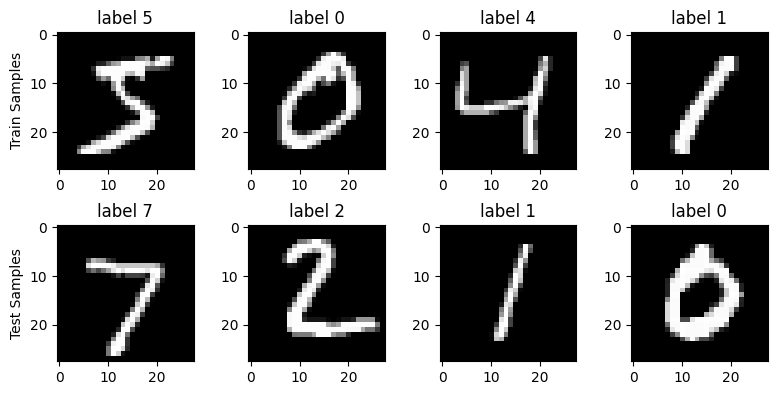

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
for sample_idx in range(4):

    train_image, train_label = train_dataset[sample_idx]
    axs[0, sample_idx].imshow(train_image.squeeze(0), cmap='grey')
    axs[0, sample_idx].set_title(f"label {train_label}")

    test_image, test_label = test_dataset[sample_idx]
    axs[1, sample_idx].imshow(test_image.squeeze(0), cmap='grey')
    axs[1, sample_idx].set_title(f"label {test_label}")

axs[0, 0].set_ylabel("Train Samples")
axs[1, 0].set_ylabel("Test Samples")
plt.tight_layout()
plt.show()

Now we build the actual network architecture.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    # initialize CNN architecture
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.size_linear = 5*5*32
        self.fc1 = nn.Linear(self.size_linear, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    # forward pass through CNN
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, self.size_linear) # flatten x to 1D vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Visualize The Network

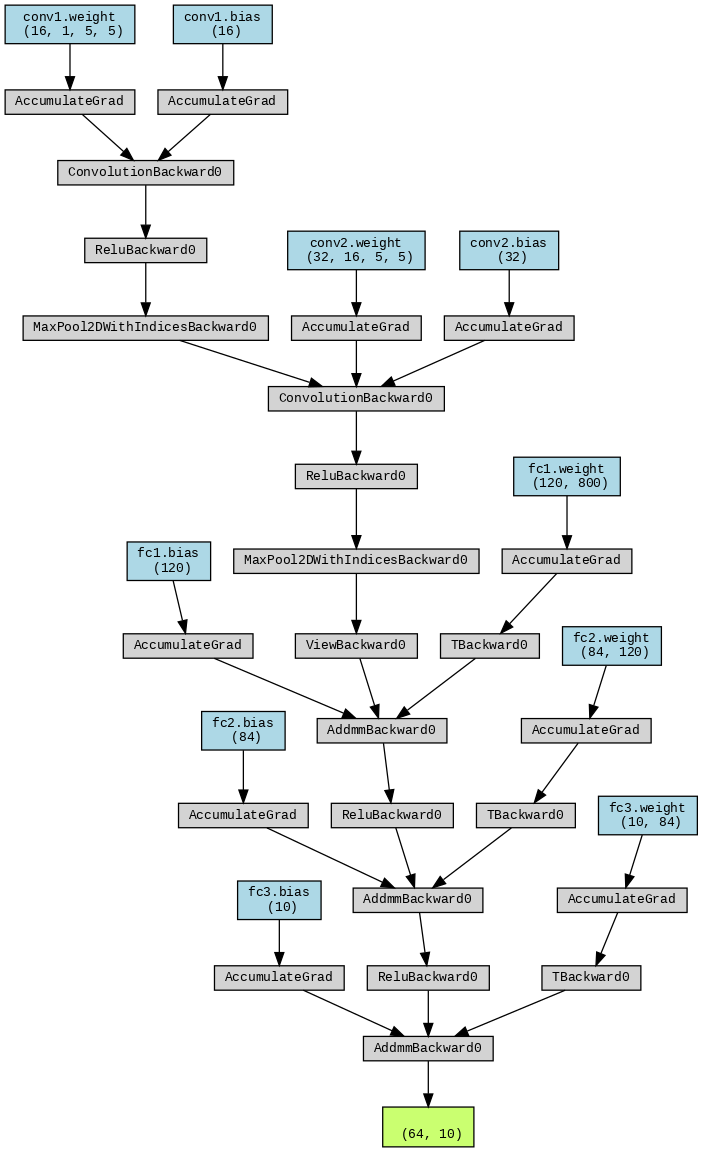

In [ ]:
from IPython.display import Image

test_data = torch.stack([train_dataset[i][0] for i in range(64)])
test_net = ConvNet()
out = test_net.forward(test_data)
dot = make_dot(out, params=dict(test_net.named_parameters()))
dot.format = "png"
dot.render(filename="network_graph")
Image(filename="network_graph.png")

### Building the trainer

The Trainer trains over all the data each epoch  (10 times in our case).
In each epoch, the trainer will call method `train_epoch`, which iterate over batches in the dataloader for training set. For each batch, it will

1. Pass the batched input into the model and obtain the logit outputs.
2. Compute the loss and accuracy of the model logits with respect to the batches labels.
3. Use `loss.backward()` to compute the gradients for each trainable parameters.
4. Update the parameters using an optimizer (e.g. SGD).

After optimizing over the training set for this epoch, the trainer will call `test_epoch`, which will pass the test data through the model and check the generalization capabilities of the trained model.


First, we define the accuracy checker for training

In [ ]:
def compute_accuracy(logits, labels):
    predicted_label = torch.argmax(logits, dim=-1)
    correct = (predicted_label == labels).sum().item()
    accuracy = correct / len(labels)
    return accuracy

Now we construct the trainer class

In [ ]:
class Trainer():
    def __init__(self,
                 net,
                 optimizer,
                 loss_function,
                 train_loader,
                 test_loader
                 ):

        self.net = net
        self.optimizer = optimizer
        self.loss_function = loss_function
        self.train_loader = train_loader
        self.test_loader = test_loader

    # trains the CNN each epoch an measures its loss and accuracy
    def train_epoch(self):
        dataloader_progress = tqdm.tqdm(self.train_loader, desc='Training') # for progress bar display

        total_loss = 0.0
        total_accuracy = 0.0
        total_steps = 0

        for data in dataloader_progress:

            # Moving this batch to GPU
            # Note that X has shape (batch_size, number of channels, height, width)
            # which is equal to (256,1,28,28)
            X = data[0].to(device)
            y = data[1].to(device)

            # Backpropagation
            self.optimizer.zero_grad()
            output = self.net(X)
            loss = self.loss_function(output, y)
            accuracy = compute_accuracy(output, y)
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
            total_accuracy += accuracy
            total_steps += 1

            dataloader_progress.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{accuracy * 100:.2f}%"})

        epoch_loss = total_loss / total_steps
        epoch_accuracy = total_accuracy / total_steps

        return epoch_loss, epoch_accuracy

    # tests the loss and accuracy of CNN after each epoch
    def test_epoch(self):
        dataloader_progress = tqdm.tqdm(self.test_loader, desc='Testing')

        total_loss = 0.0
        total_accuracy = 0.0
        total_steps = 0

        for data in dataloader_progress:

            X = data[0].to(device)
            y = data[1].to(device)

            with torch.no_grad():
              output = self.net(X)

            loss = self.loss_function(output, y)
            accuracy = compute_accuracy(output, y)

            total_loss += loss.item()
            total_accuracy += accuracy
            total_steps += 1

            dataloader_progress.set_postfix({'loss': f"{loss.item():.4f}", 'acc': f"{accuracy * 100:.2f}%"})

        epoch_loss = total_loss / total_steps
        epoch_accuracy = total_accuracy / total_steps

        return epoch_loss, epoch_accuracy

    def train(self, epochs):
        # Initialize arrays to store the losses and accuracies
        stats = {
            'train_loss': [],
            'train_acc': [],
            'test_loss': [],
            'test_acc': []
        }

        for epoch in tqdm.trange(epochs, disable=True):

            # Train the model over the training set and record the training loss / acc
            train_loss, train_acc = self.train_epoch()

            # Test the model over the testing set and record the testing loss / acc
            test_loss, test_acc = self.test_epoch()

            stats['train_loss'].append(train_loss)
            stats['test_loss'].append(test_loss)
            stats['train_acc'].append(train_acc)
            stats['test_acc'].append(test_acc)

            print(f"Epoch {epoch + 1}: train loss {train_loss:.4f}, train acc {100 * train_acc:.2f}%, test loss {test_loss:.4f}, test acc {100 * test_acc:.2f}%\n")
        return stats

### Training the network

In [ ]:
import torch.optim as optim
learning_rate = 0.01 # we set learning rate to minimize training loss

net = ConvNet()
net = net.to(device)
opt = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

trainer = Trainer(net, opt, loss_function, train_loader, test_loader)
stats = trainer.train(num_epochs)

Testing: 100%|██████████| 40/40 [00:04<00:00,  9.70it/s, loss=0.0187, acc=100.00%]


Epoch 1: train loss 0.6261, train acc 81.11%, test loss 0.1098, test acc 96.30%



Testing: 100%|██████████| 40/40 [00:04<00:00,  9.94it/s, loss=0.0017, acc=100.00%]


Epoch 2: train loss 0.1000, train acc 96.90%, test loss 0.0675, test acc 97.80%



Testing: 100%|██████████| 40/40 [00:04<00:00,  9.77it/s, loss=0.0028, acc=100.00%]


Epoch 3: train loss 0.0684, train acc 97.83%, test loss 0.0496, test acc 98.38%



Testing: 100%|██████████| 40/40 [00:04<00:00,  9.88it/s, loss=0.0006, acc=100.00%]


Epoch 4: train loss 0.0541, train acc 98.35%, test loss 0.0430, test acc 98.64%



Testing: 100%|██████████| 40/40 [00:04<00:00,  9.84it/s, loss=0.0013, acc=100.00%]


Epoch 5: train loss 0.0452, train acc 98.55%, test loss 0.0326, test acc 98.91%



Testing: 100%|██████████| 40/40 [00:04<00:00,  9.97it/s, loss=0.0003, acc=100.00%]


Epoch 6: train loss 0.0377, train acc 98.82%, test loss 0.0317, test acc 99.00%



Testing: 100%|██████████| 40/40 [00:04<00:00,  9.93it/s, loss=0.0001, acc=100.00%]


Epoch 7: train loss 0.0321, train acc 99.02%, test loss 0.0330, test acc 99.01%



Testing: 100%|██████████| 40/40 [00:04<00:00,  9.82it/s, loss=0.0003, acc=100.00%]


Epoch 8: train loss 0.0275, train acc 99.15%, test loss 0.0286, test acc 99.10%



Testing: 100%|██████████| 40/40 [00:04<00:00,  9.96it/s, loss=0.0007, acc=100.00%]


Epoch 9: train loss 0.0242, train acc 99.22%, test loss 0.0290, test acc 99.05%



Testing: 100%|██████████| 40/40 [00:04<00:00,  9.97it/s, loss=0.0009, acc=100.00%]

Epoch 10: train loss 0.0219, train acc 99.33%, test loss 0.0279, test acc 99.14%



### Visualize training trajectory

We now plot training and testing statistics: specifically the loss and eror rate of our model

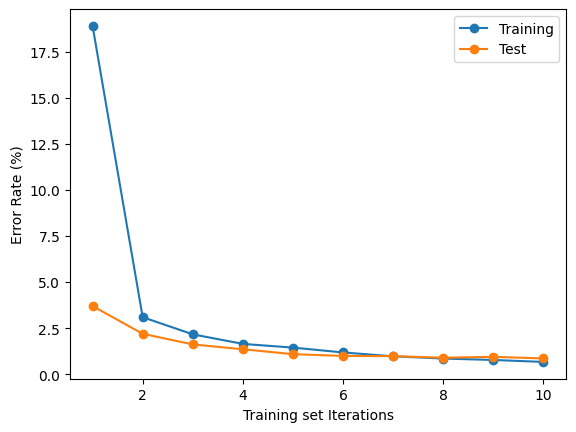

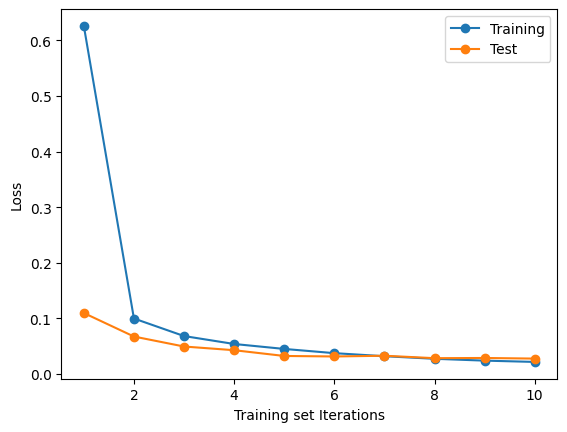

In [ ]:
# Error rate (1 - accuracy)
plt.plot(np.arange(1, num_epochs + 1), 100*(1 - np.array(stats['train_acc'])), linestyle='-', marker='o', label='Training')
plt.plot(np.arange(1, num_epochs + 1), 100*(1 - np.array(stats['test_acc'])), linestyle='-', marker='o', label='Test')
plt.xlabel("Training set Iterations")
plt.ylabel("Error Rate (%)")
plt.legend()
plt.show()

# Loss
plt.plot(np.arange(1, num_epochs + 1), np.array(stats['train_loss']), linestyle='-', marker='o', label='Training')
plt.plot(np.arange(1, num_epochs + 1), np.array(stats['test_loss']), linestyle='-', marker='o', label='Test')
plt.xlabel("Training set Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Inspecting Model Errors

We want to check which types of images our model classifies incorrectly. We expect these to be images that would be mildly challenging for a human to assign the correct digit to.

In [ ]:
def sorted_softmax_prob(logits, topk=3):
    # Compute the softmax probabilities of the logits using torch.
    p_inds = nn.functional.softmax(logits, dim=1).flatten()
    top_p, top_inds = torch.sort(p_inds, descending=True)
    return top_p[:topk], top_inds[:topk]

Call the function in the visualization script below to check the error

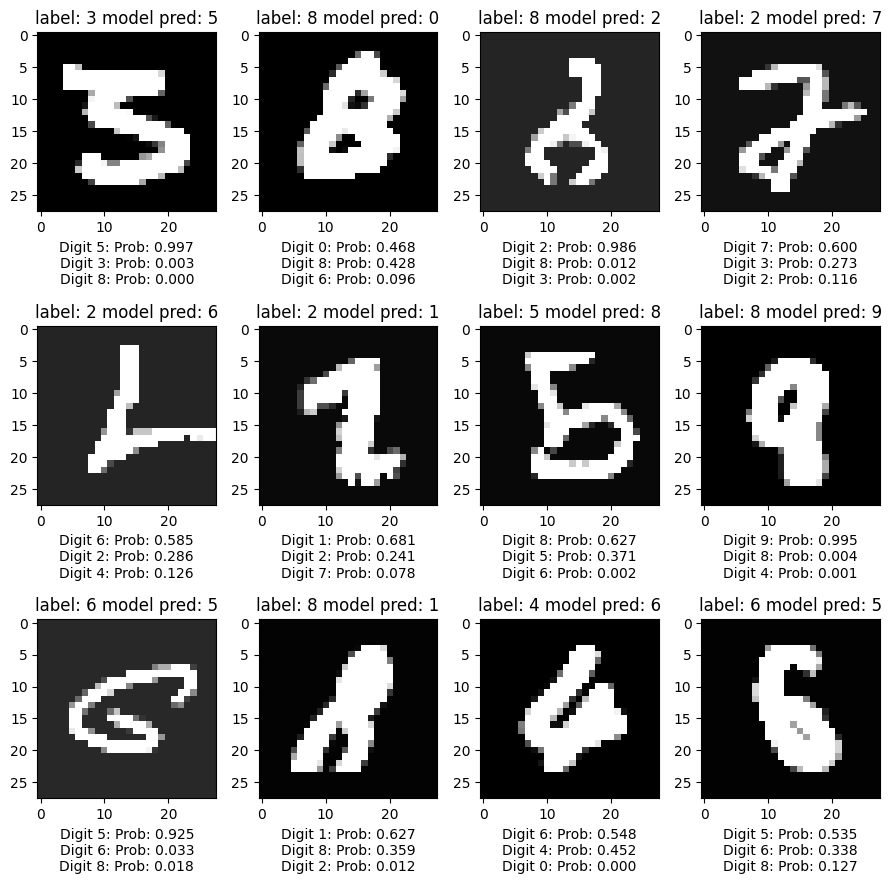

In [ ]:
def normalize_image(npimg):
    npimg = (npimg - np.mean(npimg)) / np.std(npimg)
    npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
    return npimg

num_to_check = 12
num_checked = 0
test_loader_for_error_analysis = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=0)
net.eval()

fig, axes = plt.subplots(3, 4, figsize=(9, 9))

with torch.no_grad():

    for data in test_loader_for_error_analysis:
        X = data[0].to(device)
        y = data[1].to(device)

        # Get the logit prediction from the model
        output = net(X)
        _, yh = torch.max(output, 1)

        if yh.item() != y.item():

            npimg = X[0][0].to('cpu').numpy()
            npimg = normalize_image(npimg)
            axes[num_checked // 4, num_checked % 4].imshow(npimg, cmap="gray", vmin=0, vmax=1)
            axes[num_checked // 4, num_checked % 4].set_title(f"label: {y.item()} model pred: {yh.item()}")

            top_p, top_inds = sorted_softmax_prob(output)

            top_possibility_str = []
            for p, ind in zip(top_p, top_inds):
              top_possibility_str.append(f"Digit {ind}: Prob: {p:.3f}")
            axes[num_checked // 4, num_checked % 4].set_xlabel("\n".join(top_possibility_str))
            num_checked += 1

            if num_checked == num_to_check:
                break

plt.tight_layout()
plt.show()

About half of the mistakes aren't obvious so our model is performing fairly well, although it does have gaps.